In [1]:
import pandas as pd
import glob
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
## Funções

In [3]:
def convert_to_numb(x):
    
    try:
        
        x = x.strip('0') \
             .replace(',','.')

        x = float(x)
        
        return x
        
    except:
        
        return None
    
def convert_d(row):
    
    cols_acerto = [col for col in row.index
                   if '_ACERTO' in col and
                      'D0' in col]

    for col in cols_acerto:

        d = col.split('_')[0]

        col_total = d + '_TOTAL'
        
        try:
            
            if float(row[col_total]) > 0:

                row[d] = float(row[col]) / float(row[col_total])

            else:

                row[d] = 0
        
        except:
            
            row[d] = 0

    return row

In [4]:
# Devido a incosistência dos dados nas bases de 2017
# optou-se por utilizar a base de 2018 para analise

# Load Base de Dados
files = ['/data/batalha-de-dados/dados-ce/dados/tb_spaece_2018_mt_em.csv',
         '/data/batalha-de-dados/dados-ce/dados/tb_spaece_2018_lp_em.csv']

dfs = []

for file in files:

    df = pd.read_csv(file, 
                     sep=';', 
                     low_memory=False)
    
    df.drop_duplicates(subset=['CD_ALUNO_CRIPTO'], inplace=True)
    
    # removendo columns RP e RPA da base de dados
    drop_cols = [col for col in df.columns 
                 if 'RP_' in col or 'RPA_' in col]

    df.drop(columns=drop_cols, inplace=True)
    
    dfs.append(df)
    
sp_2018 = pd.concat(dfs)

sp_2018.fillna(0, inplace=True)

sp_2018 = sp_2018.parallel_apply(lambda x: convert_d(x), axis=1)    

# Ordernando colunas para melhor organização dos dados
cols = list(sp_2018.columns)

sp_2018 = sp_2018[sorted(cols)]

In [5]:
# Transformando
vl_cols = ['VL_PERC_ACERTOS',
           'VL_PROFICIENCIA',
           'VL_PROFICIENCIA_ERRO']

for col in vl_cols:
    
    sp_2018[col] = sp_2018[col].apply(lambda x: convert_to_numb(x))
    
    query = ~sp_2018[col].isnull()
    
    sp_2018 = sp_2018.loc[query]

<AxesSubplot:>

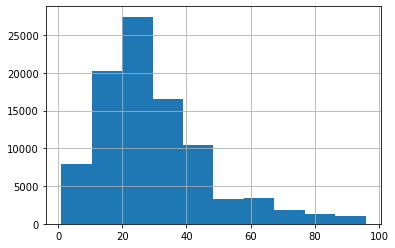

In [6]:
sp_2018['VL_PERC_ACERTOS'].hist()

<AxesSubplot:>

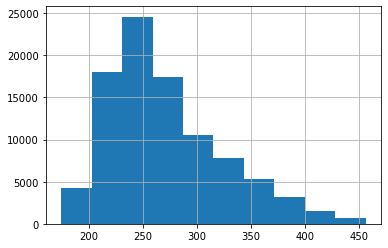

In [7]:
sp_2018['VL_PROFICIENCIA'].hist()

<AxesSubplot:>

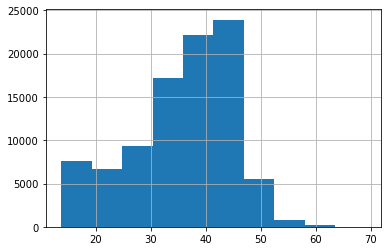

In [8]:
sp_2018['VL_PROFICIENCIA_ERRO'].hist()

In [64]:
cols = [col for col in sp_2018.columns if 'D0' in col
        and 'ACERTO' not in col 
        and 'TOTAL' not in col]

ext_cols = ['CD_ALUNO_CRIPTO','CD_DISCIPLINA','CD_TURMA_CRIPTO']

cols += ext_cols

cols += vl_cols

In [65]:
id_cols = ['CD_ALUNO_CRIPTO',
           'CD_DISCIPLINA',
           'VL_PERC_ACERTOS',
           'VL_PROFICIENCIA',
           'VL_PROFICIENCIA_ERRO']

agg_prof  = pd.melt(frame=sp_2018[cols], 
                    id_vars=id_cols,
                    var_name=['COD'],
                    value_name='NOTA')

In [12]:
agg_dicp = pd.read_csv('agg_disciplinas.csv')

In [80]:
agg_prof = agg_prof.merge(agg_dicp, 
                          how='inner', 
                          left_on=['CD_DISCIPLINA','COD'],
                          right_on=['COD_DISCIPLINA','COD'])

cols = ['COD_DISCIPLINA']

agg_prof.drop(columns=cols, inplace=True)